## Hack.lu CTF 2021 - Silver Water Industries writeup

In the challenge we are provided with some GO source code which can be found [here](https://github.com/Dexter192/CTFs/blob/main/Hack.lu%20CTF%202021/Silver%20Water%20Industries/public/main.go). This code generates a random message and encrypts it using the [**Goldwasser-Micali-cryptosystem**](https://en.wikipedia.org/wiki/Goldwasser%E2%80%93Micali_cryptosystem). 

In the challenge, we are given the public key $(N,a)$, where $N=p\cdot q$ and $a=-1$. 

In order to decrypt the encoded message $(c_1, c_2, \dots, c_n$), we require the private key $(p,q)$. If we have the private key, we can decrypt $c_i$ by checking if $c_i$ is a [quadratic residue](https://en.wikipedia.org/wiki/Quadratic_residue) modulo N, i.e., if there exists an integer x such that: $x^2 \equiv c_i \text{ mod } N$

If $c_i$ is a quadratic residue, then we set bit $m_i = 1$. Otherwise, $m_i = 0$. Doing this for all bits gives us the original message $(m_1, m_2, \dots, m_n)$

We can check if $c_i$ is a quadratic residue by calculating $c_i^{(p-1)/2}\equiv 1\mod p$ and $c^{{(q-1)/2}}\equiv 1\mod q$. However, since $c_i$, $p$ and $q$ are all large integers, this will likely give us an overflow error. 

An alternative method to check if it is a $c_i$ is a quadratic residue is by calculating the [Jacobi symbol](https://en.wikipedia.org/wiki/Jacobi_symbol). The Jacobi symbol $\left({\frac{a}{n}}\right)$ is the product of [Legendre symbols] for each prime factorization of $n$. The [Legendre symbol](https://en.wikipedia.org/wiki/Legendre_symbol) is defined as follows: 

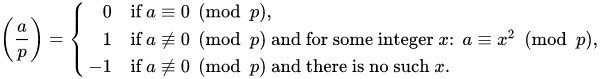

Using the Legendre symbol, we can decrypt the message as follows:

In [1]:
import pwn
import json
from cypari import pari

# Connect to server
pwn.context.log_level = 'error'
sh = pwn.remote('flu.xxx', 20060)

# Receive N
N = int(sh.recvuntil(b'\n'))
print("N: ", N)

N:  248717112594970753710635089015145389511


In [2]:
# Compute the two primfactors using cypari
factors = pari.factor(N)
p = int(factors[0][0])
q = int(factors[0][1])
print("Prime factors are p={} and q={}".format(p,q))

Prime factors are p=15410376348350331311 and q=16139587182865636201


In [3]:
# Source for Jacobi code: https://asecuritysite.com/encryption/goldwasser
def jacobi(a, n):
    if a == 0:
        return 0
    if a == 1:
        return 1

    e = 0
    a1 = a
    while a1%2==0:
        e += 1
        a1 = a1 // 2
    assert 2 ** e * a1 == a

    s = 0

    if e%2==0:
        s = 1
    elif n % 8 in {1, 7}:
        s = 1
    elif n % 8 in {3, 5}:
        s = -1

    if n % 4 == 3 and a1 % 4 == 3:
        s *= -1

    n1 = n % a1

    if a1 == 1:
        return s
    else:
        return s * jacobi(n1, a1)

In [4]:
# The jacobi symbol for one of the two factors will always be 0 (I think this is a bug and both should return the string)
# To be safe, we compute both strings and throw away the empty one
p_string = ""
q_string = ""

# From the source code, we know that we expect a message of length 20
for i in range(20):
    p_list = []
    q_list = []

    # Receive the token from the server and turn into a list of encoded bits
    token = sh.recvuntil(b'\n').decode('utf-8')
    print(token)
    j_text = token.replace(' ', ',')
    bit_enc_list = json.loads(j_text)

    # Compute the Jacobi symbol for each bit
    for bit_enc in bit_enc_list:
        # Encoded bit is 0 if jacobi(b, q) == 1 if it is -1, it is 0
        # Basically this is checking if c**((p-1)/2) is congruent to 1 mod p (and c**((q-1)/2) is congruent to 1 mod q)
        bit_p = 1 if jacobi(bit_enc, p) == -1 else 0
        bit_q = 1 if jacobi(bit_enc, q) == -1 else 0

        p_list.append(bit_p)
        q_list.append(bit_q)

    # Turn the bit array into an int
    p_int = int("".join(str(i) for i in p_list),2)
    q_int = int("".join(str(i) for i in q_list),2)

    # and the int into a char which we append to the string
    p_string = p_string + chr(p_int)
    q_string = q_string + chr(q_int)

# Throw away the empty string and send the decoded string to the server
if not p_string[0] == '\x00':
    msg = p_string.format()
else:
    msg = q_string.format()

[181835648058226969047204292458197048971 231534013682053426000013393492090827562 175395200091718383235865187450520634973 187026641593733662800728641094554745232 1311176162996742335684091141517673178 35978590366067457923783237630294317865 19622110064869041551324077912385380466 69097982603657815927145776701210961248]

[176447136217570795208795948188472662683 142500897770388549087075010307353200612 60025693622084183068061047084482005407 139459374980649593967848783185904014065 76992016221494157894181605184881987214 229300290812478786160637728909804973305 12720039913878585734671251292928405964 13175100868269983032665969908191077269]

[51876868130017665707728890333312437355 64232958373112548719109254588545491941 25164545950282185541304313393675681595 173672098251074424977321551567763330488 191819361407623104815649981026352663318 225203508480309270970380096685459692304 194530637612334888219072618286866093906 160438425282124612893437501490903219473]

[221361640689365454847078156102648544200 59

In [5]:
print('Decoded string: {}'.format(msg))
sh.sendline(msg.encode('utf-8'))

# Receive empty line before our flag
sh.recvuntil(b'\n')
flag = sh.recvuntil(b'\n')
print(flag.decode('utf-8'))

Decoded string: lMYiZv9T7pkdMrpUXr0U
flag{Oh_NO_aT_LEast_mY_AlGORithM_is_ExpanDiNg}

